# Module 1 lecture Examples

Data Source: http://lib.stat.cmu.edu/datasets/CPS_85_Wages

Determinants of Wages from the 1985 Current Population Survey

Summary:
	The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages. 
	Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, p < .0001). The effect of age was not significant after controlling for experience. Standardized residual plots showed no patterns, except for one large outlier with lower wages than expected. This was a male, with 22 years of experience and 12 years of education, in a management position, who lived in the north and was not a union member. Removing this person from the analysis did not substantially change the results, so that the final model included the entire sample. 
	Adjusting for all other variables in the model, females earned 81% (75%, 88%) the wages of males (p < .0001). Wages increased 41% (28%, 56%) for every 5 additional years of education (p < .0001). They increased by 11% (7%, 14%) for every additional 10 years of experience (p < .0001). Union members were paid 23% (12%, 36%) more than non-union members (p < .0001). Northerns were paid 11% (2%, 20%) more than southerns (p =.016). Management and professional positions were paid most, and service and clerical positions were paid least (pooled F-test, p < .0001). Overall variance explained was R2 = .35. 
	In summary, many factors describe the variations in wages: occupational status, years of experience, years of education, sex, union membership and region of residence. However, despite adjustment for all factors that were available, there still appeared to be a gender gap in wages. There is no readily available explanation for this gender gap.

Authorization: Public Domain

Reference: Berndt, ER. The Practice of Econometrics. 1991. NY: Addison-Wesley.

Description:  The datafile contains 534 observations on 11 variables sampled from the Current Population Survey of 1985.  This data set demonstrates multiple regression, confounding, transformations, multicollinearity, categorical variables, ANOVA, pooled tests of significance, interactions and model building strategies.

Variable names in order from left to right:
	EDUCATION: Number of years of education.
	SOUTH: Indicator variable for Southern Region (1=Person lives in 		South, 0=Person lives elsewhere).
	SEX: Indicator variable for sex (1=Female, 0=Male).
	EXPERIENCE: Number of years of work experience.
	UNION: Indicator variable for union membership (1=Union member, 		0=Not union member).
	WAGE: Wage (dollars per hour).
	AGE: Age (years).
	RACE: Race (1=Other, 2=Hispanic, 3=White).
	OCCUPATION: Occupational category (1=Management, 		2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other).
	SECTOR: Sector (0=Other, 1=Manufacturing, 2=Construction).
	MARR: Marital Status (0=Unmarried,  1=Married)

In [14]:
#import statements
import numpy as np 
from numpy import mean, absolute
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
import os
import lxml as lxml


## Regression Trees

In [96]:
#Read the data file starting at line 27 after the header lines. Set columns as defined in the header section.
columns = ['EDUCATION','SOUTH','SEX','EXPERIENCE','UNION','WAGE','AGE','RACE','OCCUPATION','SECTOR','MARR']

data = []
lineNum = 0
with open('salary.txt', 'r') as reader:
    for i, line in enumerate(reader):
        if i>=27:
            data.append(line.replace('\n','').split('\t'))

df = pd.DataFrame(data, columns = columns)

In [97]:
#determine whether there are any null values in the data set
df.isnull().any()

EDUCATION     False
SOUTH          True
SEX            True
EXPERIENCE     True
UNION          True
WAGE           True
AGE            True
RACE           True
OCCUPATION     True
SECTOR         True
MARR           True
dtype: bool

In [98]:
#Remove rows with missing values
df = df.dropna()

In [99]:
df.nunique()

EDUCATION      17
SOUTH           2
SEX             2
EXPERIENCE     52
UNION           2
WAGE          238
AGE            47
RACE            3
OCCUPATION      6
SECTOR          3
MARR            2
dtype: int64

In [104]:
df = df.astype({'EDUCATION':np.float16, 'SOUTH':int, 'SEX':int, 'EXPERIENCE':int, 'UNION':int, 'WAGE': np.float16, 'AGE':int,
            'RACE':int,'OCCUPATION':int, 'SECTOR':int,'MARR':int})

In [105]:
df.dtypes

EDUCATION     float16
SOUTH           int64
SEX             int64
EXPERIENCE      int64
UNION           int64
WAGE          float16
AGE             int64
RACE            int64
OCCUPATION      int64
SECTOR          int64
MARR            int64
dtype: object

## Create feature and target arrays where target=Wage.


In [106]:
cols = list(df.columns)
target_col = 'WAGE'
cols.remove(target_col)

X=df[cols]
y=df[target_col]

## Define the training and test data sets

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, random_state=12345)

## Train the regression tree with default parameters

In [108]:
regr = DecisionTreeRegressor(random_state=12345)

regr.fit(X_train, y_train)
pred = regr.predict(X_test)

In [109]:
regr.score(X_test,y_test)

0.03871144257424486

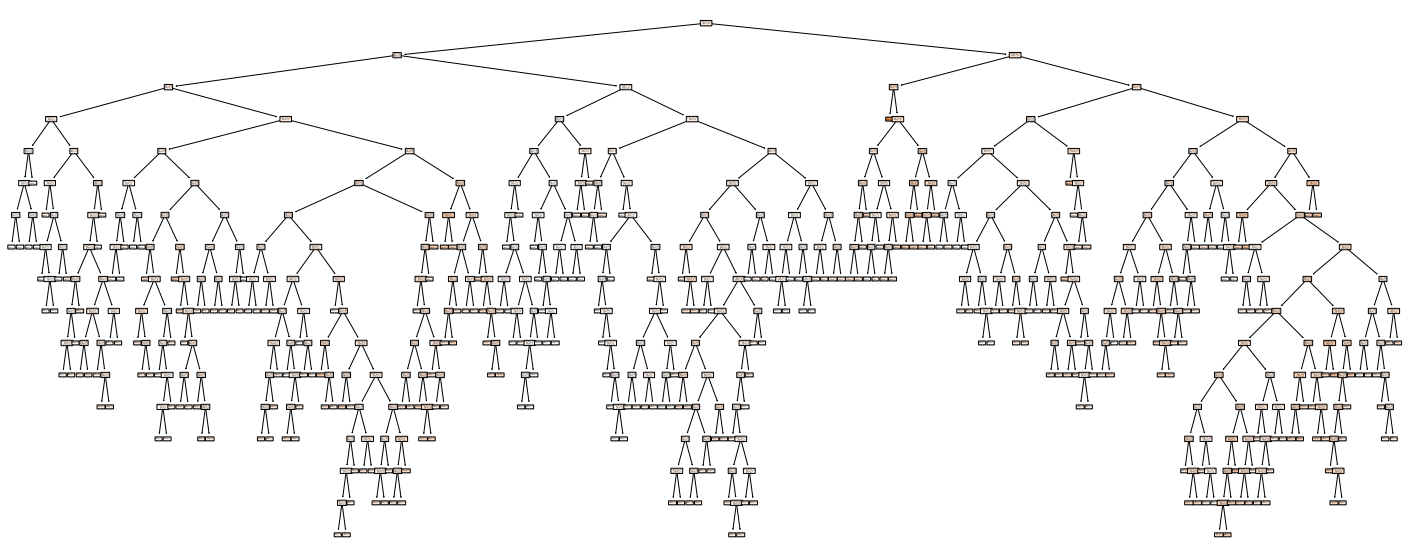

In [110]:
plt.figure(figsize=(25,10))
a = tree.plot_tree(regr,
                    feature_names = list(X.columns),
                    filled = True,
                    rounded = True)

## Create a function to prune the tree

In [111]:
def lowest_mse(X_train, X_test, y_train, y_test, max_depth=30,min_samples_leaf=30,max_leaf_nodes=30):
    """Prune model by testing values of max depth, min samples leaf and max leaf nodes. Return the model
    with the least complexity and lowest mean squared error"""
    mse = []
    maxDepthList = []
    minSamplesLeafList = []
    maxLeafNodes = []
    for i in range(1,max_depth):
        for j in range(2,min_samples_leaf):
            for k in range(2,max_leaf_nodes):
                dtree = DecisionTreeRegressor(random_state=0,max_depth=i, min_samples_leaf=j, max_leaf_nodes=k)
                dtree.fit(X_train, y_train)
                pred = dtree.predict(X_test)
                mse.append(mean_squared_error(y_test, pred))
                maxDepthList.append(i)
                minSamplesLeafList.append(j)
                maxLeafNodes.append(k)
    dfModels = pd.DataFrame({'mse': pd.Series(mse),
                    'max depth': pd.Series(maxDepthList),
                    'min samples leaf': pd.Series(minSamplesLeafList),
                    'max leaf nodes': pd.Series(maxLeafNodes)})
    #sort the dataframe by mse and complexity
    dfModels = dfModels.sort_values(by=['mse','max depth','min samples leaf','max leaf nodes']).reset_index()
    #return the pruned model
    prunedTree = DecisionTreeRegressor(random_state=0,max_depth=dfModels['max depth'][0], min_samples_leaf=dfModels['min samples leaf'][0], max_leaf_nodes=dfModels['max leaf nodes'][0])
    prunedTree.fit(X_train, y_train)
    return prunedTree
    

In [112]:
prunedTree = lowest_mse(X_train, X_test, y_train, y_test)

## Plot pruned tree

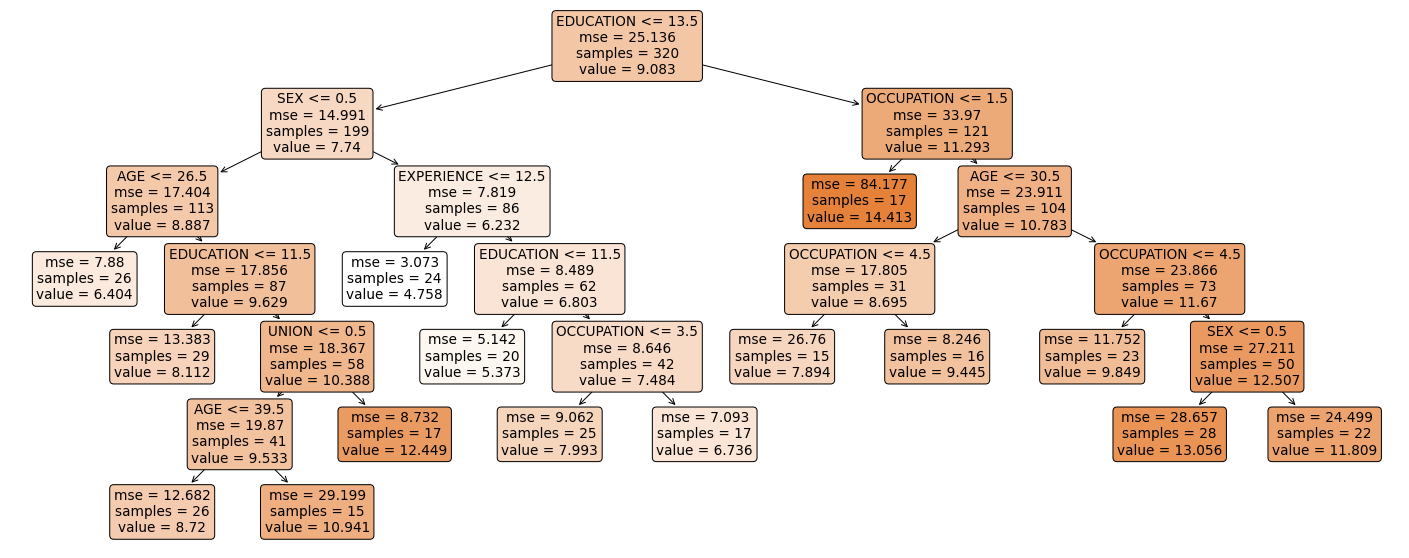

In [113]:
plt.figure(figsize=(25,10))
a = tree.plot_tree(prunedTree,
                    feature_names = list(X.columns),
                    filled = True,
                    rounded = True)

### Estimate vs Estimate plots

In [115]:
trainingScores = pd.DataFrame(y_train)
trainingScores['Prediction'] = prunedTree.predict(X_train)
trainingScores['Residual'] = trainingScores['WAGE']-trainingScores['Prediction']

validationScores = pd.DataFrame(y_test)
validationScores['Prediction'] = prunedTree.predict(X_test)
validationScores['Residual'] = validationScores['WAGE']-validationScores['Prediction']

In [116]:
trainingScores.head()

,WAGE,Prediction,Residual
239,13.710938,12.448989,1.261949
378,1.750000,4.757731,-3.007731
213,13.328125,9.848760,3.479365
112,15.000000,12.448989,2.551011
182,19.000000,14.412799,4.587201


## Plot the Estimate vs Estimate plots for Training and Validation Data

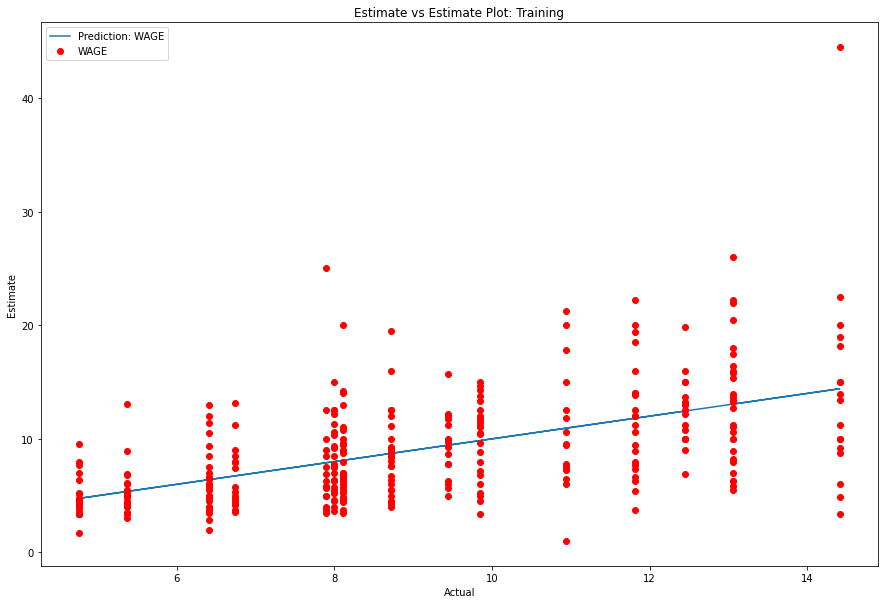

In [117]:
plt.figure(figsize=(15,10))
a = plt.plot(trainingScores['Prediction'],trainingScores['Prediction'],label='Prediction: WAGE')
b = plt.plot(trainingScores['Prediction'],trainingScores['WAGE'],'ro', label='WAGE')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: Training')
plt.legend()

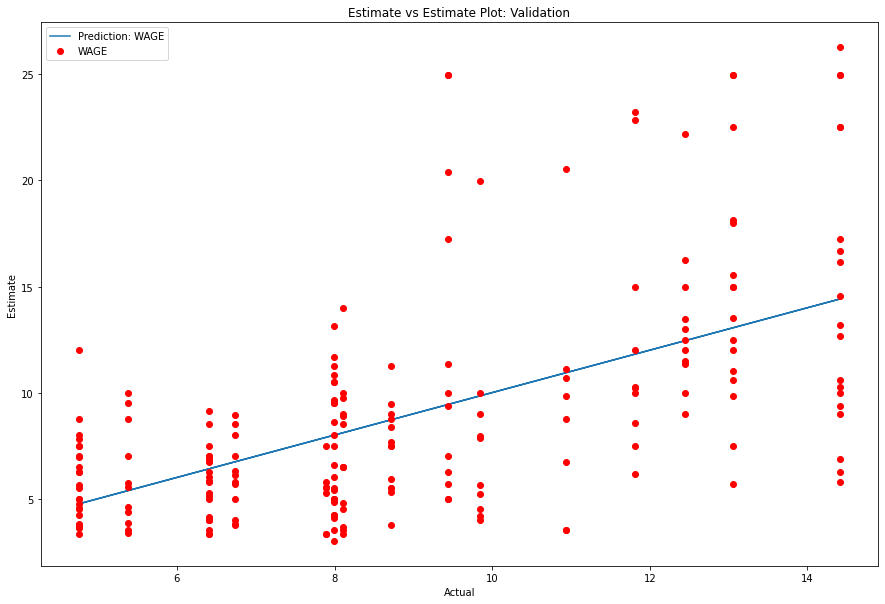

In [118]:
plt.figure(figsize=(15,10))
a = plt.plot(validationScores['Prediction'],validationScores['Prediction'],label='Prediction: WAGE')
a1 = plt.plot(validationScores['Prediction'],validationScores['WAGE'],'ro', label='WAGE')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: Validation')
plt.legend()

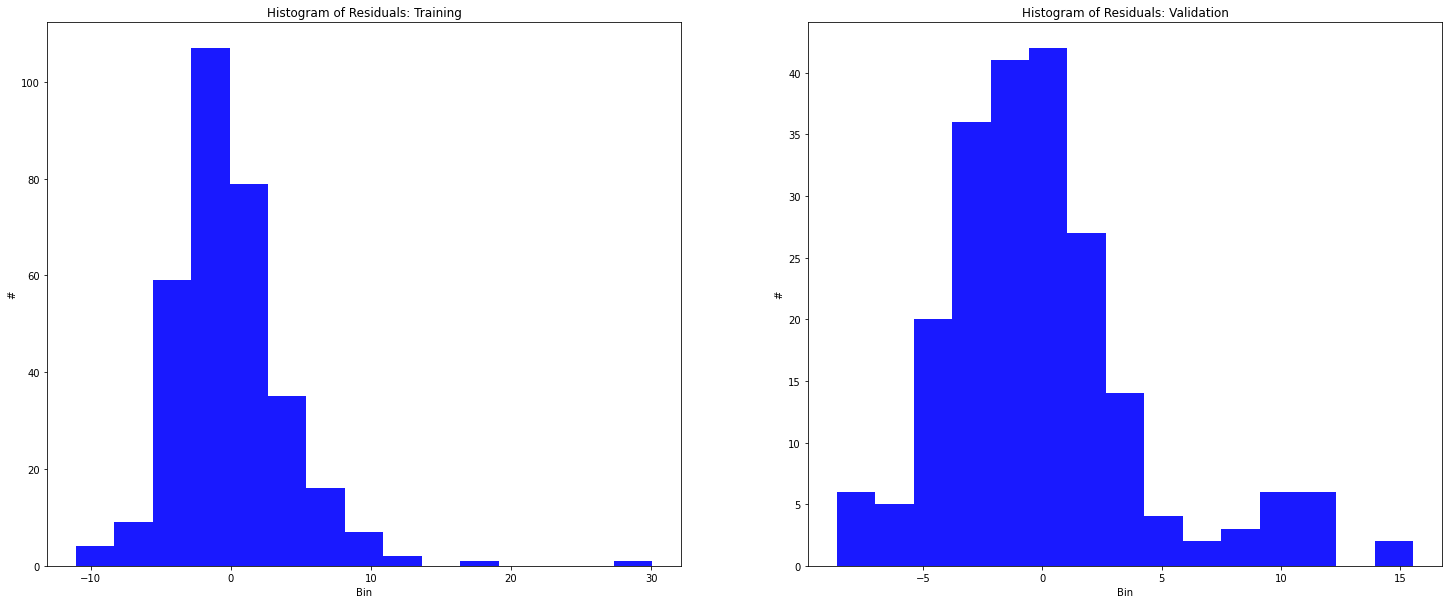

In [119]:
plt.figure(figsize=(25,10))

plt.subplot(121)
n, bins, patchs = plt.hist(trainingScores['Residual'], 15, facecolor='b',alpha=.9)
plt.xlabel('Bin')
plt.ylabel('#')
plt.title('Histogram of Residuals: Training')

plt.subplot(122)
n, bins, patchs = plt.hist(validationScores['Residual'], 15, facecolor='b',alpha=.9)
plt.xlabel('Bin')
plt.ylabel('#')
plt.title('Histogram of Residuals: Validation')
plt.show()

## Model scoring and comparison

In [120]:
data = {'SSE': [sum(trainingScores['Residual']**2),sum(validationScores['Residual']**2)],
        'MSE': [mean_squared_error(trainingScores['WAGE'], trainingScores['Prediction']), mean_squared_error(validationScores['WAGE'], validationScores['Prediction'])],
        'RMSE': [mean_squared_error(trainingScores['WAGE'], trainingScores['Prediction'])**.5, mean_squared_error(validationScores['WAGE'], validationScores['Prediction'])**.5],
        'MAD': [mean(absolute(trainingScores['Residual'])),mean(absolute(validationScores['Residual']))],
        'R2': [r2_score(trainingScores['WAGE'], trainingScores['Prediction']), r2_score(validationScores['WAGE'], validationScores['Prediction'])]}

In [121]:
dfSummary = pd.DataFrame.from_dict(data, orient='index', columns=['Training', 'Validation'])
dfSummary['%Difference'] = (dfSummary['Training']-dfSummary['Validation'])/dfSummary['Training']*100
dfSummary

,Training,Validation,%Difference
SSE,5608.873957,3850.681850,31.346615
MSE,17.527731,17.993840,-2.659268
RMSE,4.186613,4.241915,-1.320910
MAD,2.976654,3.063765,-2.926470
R2,0.302584,0.361605,-19.505626


## Feature Importance


In [122]:
dfFeatures = pd.DataFrame(zip(X.columns, prunedTree.feature_importances_),columns=['Feature','Importance'])
dfFeatures['Importance'] = dfFeatures['Importance'].replace(0, np.nan)
dfFeatures['Rank'] = dfFeatures['Importance'].rank(method='max', ascending=False)
dfFeatures

,Feature,Importance,Rank
0,EDUCATION,0.456090,1.0
1,SOUTH,NaN,NaN
2,SEX,0.149240,3.0
3,EXPERIENCE,0.029735,6.0
4,UNION,0.041972,5.0
5,AGE,0.183925,2.0
6,RACE,NaN,NaN
7,OCCUPATION,0.139037,4.0
8,SECTOR,NaN,NaN
9,MARR,NaN,NaN
